# Automatic diagnosis of Alzheimer's disease using Deep Learning

## Introduction

Alzheimers 

"Alzheimer's disease (AD), also referred to simply as Alzheimer's, is a chronic neurodegenerative disease that usually starts slowly and gradually worsens over time. It is the cause of 60–70% of cases of dementia. The most common early symptom is difficulty in remembering recent events. As the disease advances, symptoms can include problems with language, disorientation (including easily getting lost), mood swings, loss of motivation, not managing self-care, and behavioural issues. As a person's condition declines, they often withdraw from family and society. Gradually, bodily functions are lost, ultimately leading to death. Although the speed of progression can vary, the typical life expectancy following diagnosis is three to nine years." -wikipedia.org

For this lab, we are going to use the following packages:

- nibabel
- tensorflow 2.0 or greater
- tensorboard
- nilearn
- numpy
- scikit-learn

Furthermore, for some preprocessing we use:
- Matlab 2019b

Please make sure he have installed all required packages for python and installed Matlab. We suggest that you use anaconda and create an new python environment 

## PET Scan Images: Analysing the brain

A positron emission tomography (PET) scan is an imaging test that allows your doctor to check for diseases in your body.
The scan uses a special dye containing radioactive tracers. These tracers are either swallowed, inhaled, or injected into a vein in your arm depending on what part of the body is being examined. Certain organs and tissues then absorb the tracer.
When detected by a PET scanner, the tracers help your doctor to see how well your organs and tissues are working.

Glucose is the main fuel of the brain. During PET scans, tracers are “attached” to compounds such as glucose. By detecting radioactive glucose, the PET scan is able to detect which areas of the brain are utilizing glucose at the highest rates.

PET scans are used to help diagnose and manage many central nervous system (CNS) disorders, such as Alzheimer's disease

### Visualizing the Data

Before we do any preperations on the images we are going to use for our classificaiton study, it is always a good idea to inspect the data. This way we can identfiy issues that would need to be resolved, such as normalizing, removing noisy images, segment important parts or crop/resize the image. 

Lets import some modules:

In [1]:
#Loading modules
import os 
import sys
import numpy as np
import pathlib
import matplotlib.pyplot as plt
import pandas as pd
import nibabel as nib
from sklearn.preprocessing import MinMaxScaler

Our images are in 3D NIFTI format. To load this type of data, we use the python library nibabel: 

In [2]:
#example images. Make sure to path to folder
IMG_BASE_PATH = os.path.dirname(os.path.abspath("Lab.ipynb"))
example_brain1 = nib.load(IMG_BASE_PATH + '/normal_raw/s123_S_0106-0004-02001-000081.nii')
example_brain2 = nib.load(IMG_BASE_PATH + '/normal_raw/s126_S_0680-0003-00001-000047.nii')
example_brain3 = nib.load(IMG_BASE_PATH + '/normal_raw/s129_S_4422-0001-00001-000001.nii')

After loading three examples, we can plot them using the nilearn library. Nilearn is similar to sklearn, providing tool and algorithms for neuro-imaging tasks. We primarily use the nice plotting utilities of this library. Lets plot the three examples: 

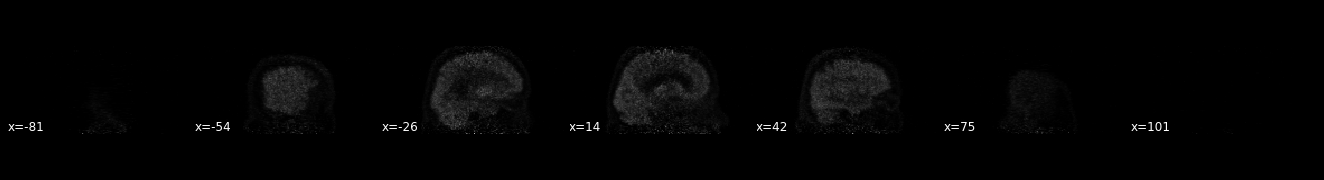

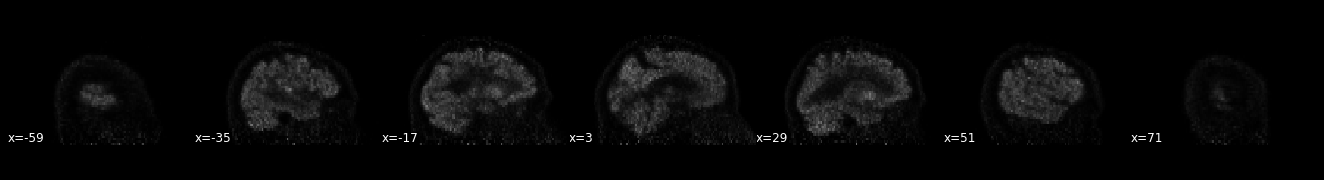

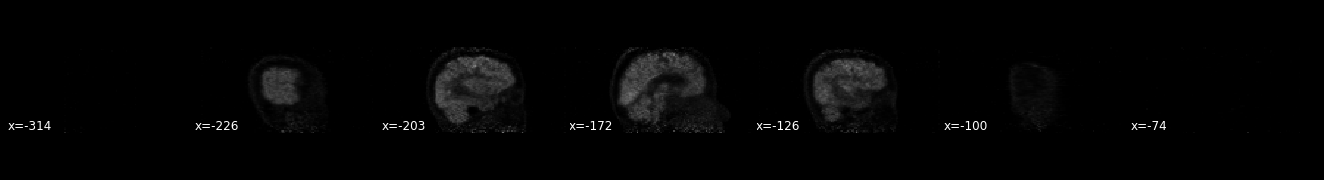

In [3]:
#import plotting functions
from nilearn.plotting import view_img, plot_anat

#display brains
plot_anat(example_brain1, draw_cross=False, display_mode ="x")
plot_anat(example_brain2, draw_cross=False, display_mode ="x")
plot_anat(example_brain3, draw_cross=False, display_mode ="x")

If you want to learn more about a particular functions and its parameters use "?" after the function name:

In [4]:
plot_anat?

Signature:
plot_anat(
    anat_img=<MNI152Template>,
    cut_coords=None,
    output_file=None,
    display_mode='ortho',
    figure=None,
    axes=None,
    title=None,
    annotate=True,
    threshold=None,
    draw_cross=True,
    black_bg='auto',
    dim='auto',
    cmap=<matplotlib.colors.LinearSegmentedColormap object at 0x7f06bc031be0>,
    vmin=None,
    vmax=None,
    **kwargs,
)
Docstring:
Plot cuts of an anatomical image (by default 3 cuts:
Frontal, Axial, and Lateral)

Parameters
----------
anat_img : Niimg-like object
    See http://nilearn.github.io/manipulating_images/input_output.html
    The anatomical image to be used as a background. If None is
    given, nilearn tries to find a T1 template.
cut_coords : None, a tuple of floats, or an integer
    The MNI coordinates of the point where the cut is performed
    If display_mode is 'ortho' or 'tiled',
    this should be a 3-tuple: (x, y, z)
    For display_mode == 'x', 'y', or 'z', then these are the
    coordinates of e

Play around with the parameters to show different views of the data. For example, change the <strong>display_mode</strong> parameter to "x" to show a sagittal view of the skull. There are more brains in the example folder, display them to get a better idea what problems you may need to solve before you can construct your classifcation model.

### Problems using the raw data directly

You may have noticed that images come in differnt sizes, the brightness of the images are different. Most images contain the skull and other soft tissues aside from the brain. To get good results for our classifcation problem, we need preprocess the data. Before we do this, run the following command:

In [6]:
view_img(nib.load(IMG_BASE_PATH + '/normal_raw/s123_S_0106-0004-02001-000081.nii'))

BoundingBoxError: The field of view given by the target affine does not contain any of the data

You might get the error: "The field of view given by the target affine does not contain any of the data". This happens because the image origin is not set appropriatly and the plotting functions does not find any data in the area where the origin is set. We will elivate this problem and do other preprocessing steps in the next sections.

## Learning to classify unhealthy brains

### Preprocessing
For the normalizing steps, we will use Matlab with the Statistical Parameter Mapping (SPM) library, allowing the fast and easy visualization of nifti image files. You can do much more with this library, but we concentrate on preprocessing our raw files for classifcation.
#### Normalizing Images using Matlab and SPM

##### Installing SPM

1. Make sure that you have newest version of Matlab installed (2019b). Download SPM12 from the following link:
https://www.fil.ion.ucl.ac.uk/spm/software/download/

You are required to fill in a short form. You don't need to fill in "Additional Comments"!. 

2. After downloading the spm12.zip. We recomment you to unpack the zip file in the main folder of this lab.

3. Open Matlab and type into the command window to add SPM to the working directory:
`addpath <path to SPM folder>`

Were `<path to SPM folder>` is the path where you unpacked the zip file: For example:
`addpath C:\Lab\SPM\`

4. Type `spm` into the command window to start SPM. This may take a while.

5. You will see a small window, click on `PET & VBM`.

##### Importing dicom images

We have seen how to plot nifti files, but petscan usually come as single images of slices, so called dicom files, that need to be compiled into 3D nifti file. 

1. To do this, click on "DICOM Import" under "SPM for PET & VBM" in the menu.
2. In the Batch Editor window on the right side click on `DICOM files      <-X`. a new window will open.
3. Select the *dcm files in the dcm_files folder and click "Done"
4. In the Batch Editor window again, select the `Output directory` and select the nii_files folder in the Lab folder.
5. In the Batch Editor window, click the green triangle on the task bar to start the conversion.

##### Setting the Image origin

Now that you have converted the dicom files to nifti, we need to set the origin of the image. This is required not only for plotting the data later, but for our preprocessing algorithms to work properly.

1. In the SPM menu, click on Display
2. Select one of the nifti files in the folder nii_files

You will see a view of the image in the Graphics window. The origin of the nifti file sould be set to the "anterior commissure" of the brain.

If you are unsure how to do this, please refer to this video:
https://www.youtube.com/watch?v=AwNJAUKLhqY

Since our PET images are of low quality, try to find an approximate "middle" of the brain. This is most of the time good enough for the segmentation alogorithms.

3. Select the origin using the blue crosses in the image.
4. At the bottom, click on "Set Origin"
5. Click on "Reorient" and overwrite the original nifti-file.

You do not need to do this for all files. If you chose to do this only for one image, remember the file name!

##### Normalization

The brightness of the images need to be normalized to ensure even signal strength for all images.
To to this, we use the "Normalise (Est & Wri)" function in SPM

1. in the menu under "spatial pre-processing", click on the drop-down menu "Normalise" and select "Normalise (Est & Wri)".
2. in the new window, click on "Data     <-X"
3. Set image to align and image to write to the nifti file that we set the origin on.
4. Click the green triangle in the task bar to start normalization.

Normalization may take a while.

##### Segementation: Keeping the Brain

After normalizing the image, we segment the most important part: The brain.

1. In the menu under "spatial pre-processing", click on "Segment".
2. Under Data -> Channel -> Volumes set the nifti file that has been created after normalization the filename should start with "w"
3. Click the green triangle in the task bar to start segmentation.

##### Final image calculation

After segmentation, several files have been created that need to be combined into a single nifti file. To do this, we use the ImCalc tool in the menu.

1. Under Input Images set the nifti filename beginning with w then c1, c2, c3
2. Under Expression type i1.*((i2+i3+i4)>0.5)
3. Under Output Filename make the field empty (remove 'output')

after all is done. A new images has been created, you can new Display the image if you want to inspect the result!

### Loading the data into our python evironment

You may have noticed that preprocessing is quite laborious. We provide you with already preprocessed files in the folders "normal_final" and "ad_final".

We again, can use the nibabel library to load the data and view the preprocessed images:

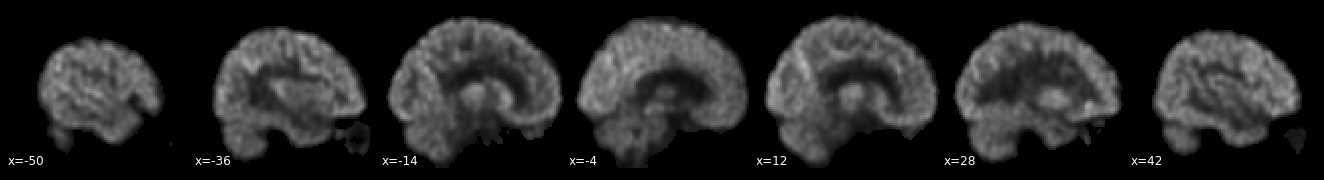

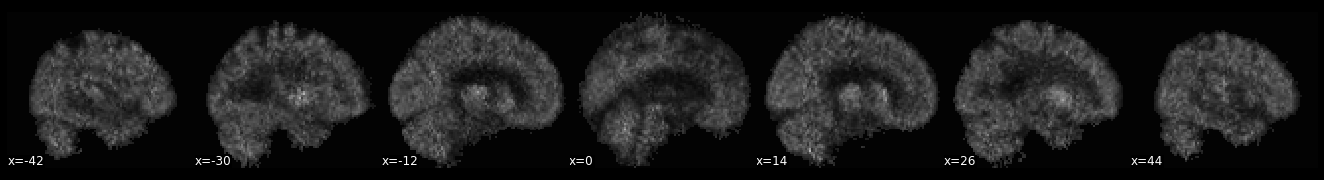

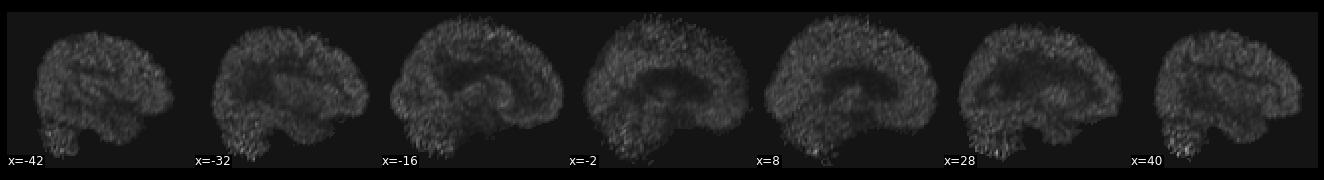

In [7]:
IMG_BASE_PATH = os.path.dirname(os.path.abspath("Lab.ipynb"))
example_brain1_norm = nib.load(IMG_BASE_PATH + '/normal_final/iws002_S_0413-303700-00001-000001.nii')
example_brain2_norm = nib.load(IMG_BASE_PATH + '/normal_final/iws003_S_0907-0006-02001-000109.nii')
example_brain3_norm = nib.load(IMG_BASE_PATH + '/normal_final/iws007_S_1206-0401-00047-000047.nii')

plot_anat(example_brain1_norm, draw_cross=False, display_mode ="x")
plot_anat(example_brain2_norm, draw_cross=False, display_mode ="x")
plot_anat(example_brain3_norm, draw_cross=False, display_mode ="x")

As you can see, the skull has been removed from the images and the images are of the same size.
Since all preprocessed images have valid origins, we can use the view_img function to display an interactive plot similar to what you have seen in SPM.


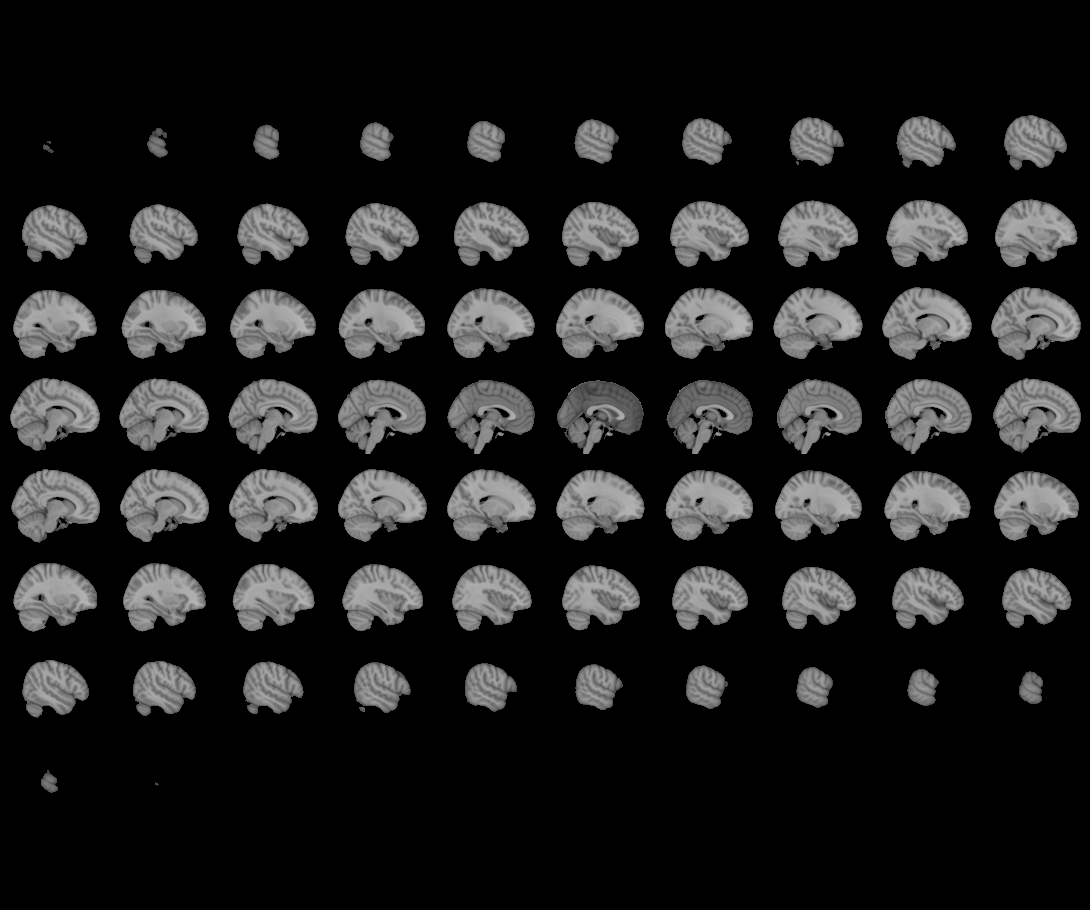
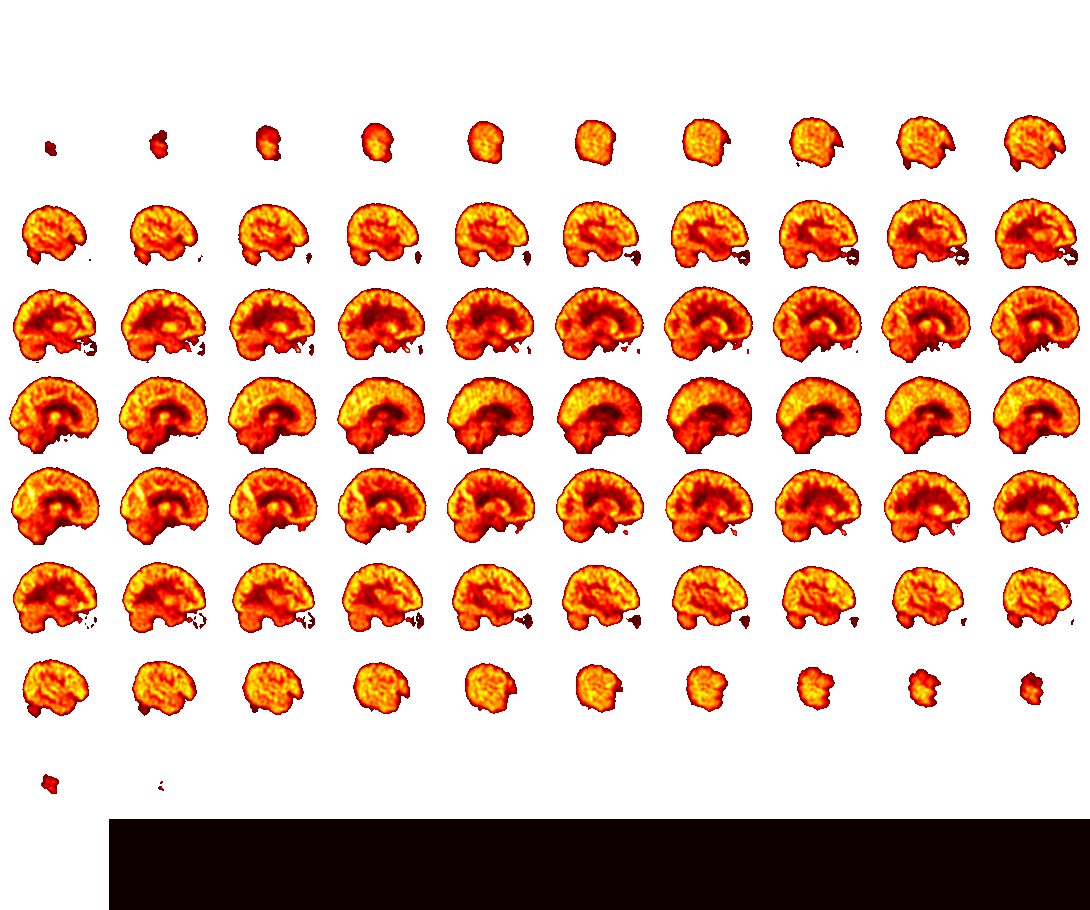

In [8]:
view_img(example_brain1_norm)

Since our model expects data input in the form of numpy arrays, we load the data and save it into variables for easy access. First we define the loading function:

In [9]:
#Loading function
def load_all_nii_data(path,filenames):
    data=[]
    temp=[]
    for i in range(0,len(filenames)):
        temp=nib.load(path+filenames[i])
        temp=temp.get_fdata()
        if i == 0:
            data=np.expand_dims(temp,0)
        else:
            data=np.append(data,np.expand_dims(temp,0),0)
    print('Data shape '+str(data.shape))
    return data,filenames

In [10]:
#load healthy and ill brains
IMG_BASE_PATH = os.path.dirname(os.path.abspath("Lab.ipynb"))
adni_files_normal = os.listdir(IMG_BASE_PATH + '/normal_final/')
adni_files_ill = os.listdir(IMG_BASE_PATH + '/ad_final/')
adni_data_normal, normal_names = load_all_nii_data(IMG_BASE_PATH + '/normal_final/',adni_files_normal)
adni_data_ill, ill_names = load_all_nii_data(IMG_BASE_PATH + '/ad_final/',adni_files_ill)

#concatenate into single array
all_data = np.concatenate((adni_data_normal, adni_data_ill))


Data shape (159, 79, 95, 79)
Data shape (195, 79, 95, 79)


In [11]:
all_data.shape

(354, 79, 95, 79)

### Preparing the data for learning
Now that we have loaded our data, we need to prepare it for classification

#### Normalzing brightness
As you may have notices, The preprocessed images vary in brightness. To fix this, we min-max normalize our images. First lets define a function that does this for <strong>each</strong> image. 

In [12]:
#Normalize image brightness for each image via a for loop
#The first index is the image index
def min_max_norm(x): # x is a single image
    #scaler = MinMaxScaler()
    #fit_transform = scaler.fit_transform(x) #Fit to data, then transform it.
    #find maximum value
    max_ = x.max()
    #find miminum value
    min_ = x.min()
    #min max normalize
    return (x - min_)/ (max_ - min_)
    
    #return fit_transform

In [13]:
# For test puposes
#data = [[-1, 2], [-0.5, 6], [0, 10], [1, 18]]
#print(min_max_norm(data))

And normalize the data:

In [14]:
#normalize
for i in range(0,all_data.shape[0]):
    #use function
    all_data[i,:,:,:]=min_max_norm(all_data[i,:,:,:])

#### Creating our label for learning
For our classification task, we need to tell our model what brain in our image are healthy and which are not. Lets creat our labels:

In [15]:
#placeholder array
labels= np.zeros(all_data.shape[0])
#we know that the sick brains come after the normal ones since we just concatenated the health with the sick brains
#But your code in the bracket[]
labels[:159] = 1

### Building Classification Model using Keras

Now that we have our data prepared and ready for learning, we need to define our model. We exploit the power of deep-learning models, specifically Convolutional Neural Networks, to learn to tell healthy and sick brains appart.

#### Functional API

You might be familiar with the `Sequental` model using Keras. In this Lab, we use the more powerful functional API of Keras, that allows us to design more complex model architectures. For a brief introduction, please refer to https://keras.io/getting-started/functional-api-guide/

Lets import some libraries that we need:

In [16]:
import tensorflow as tf
from pathlib import Path
import math
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import roc_auc_score, confusion_matrix, f1_score
from tensorflow.keras.layers import Add, Input, Dense, Dropout, Conv2D, MaxPooling2D, Flatten, BatchNormalization, concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adadelta, Adam
import time
from keras.regularizers import l2

In essence, the functional api allows you arbitrariy connection between layers instead of assuming a pure sequential connection between layers. It also allows you to add inputs on other layers than the input layer, providing more flexability in architecture design.

You may, for example add a skip connection between the first dense and third dense layer, "skipping" the second dense layer:

In [17]:
#input layer 100 features
input_ = Input(shape=(100,), name="input")
dense1_ = Dense(50, name="dense1")(input_)
dense2_ = Dense(50, name="dense2")(dense1_)
dense3_ = Dense(50, name="dense3")(dense2_)
dense4_ = Add(name="add")([dense1_,dense3_])
output_ = Dense(1,activation="sigmoid",name="output")(dense4_)

#create model using Model class
model = Model(inputs=input_, outputs=output_)

model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, 100)]        0                                            
__________________________________________________________________________________________________
dense1 (Dense)                  (None, 50)           5050        input[0][0]                      
__________________________________________________________________________________________________
dense2 (Dense)                  (None, 50)           2550        dense1[0][0]                     
__________________________________________________________________________________________________
dense3 (Dense)                  (None, 50)           2550        dense2[0][0]                     
______________________________________________________________________________________________

Such skip connections are heavily employed in state of the art deep neural networks for image classificaton, such as ResNet or DenseNet. For a good summary of the idea of skip connections, please see: https://towardsdatascience.com/residual-blocks-building-blocks-of-resnet-fd90ca15d6ec.

Now it is your turn, construct a simple sequential model using the functional API. Follow the architecture instructions below. If no parameter value is given, use the standard parameters.

The model is constructed of two convolutional blocks with integrated max pooling and batch normalization:

# Name each layer (name=) for easy debugging if something goes wrong!

- INPUT
- CNN (filters = 4, kernelsize 3, strides 2, activation relu, data format channel_first)
- MAXPOOLING
- BATCHNORMALIZATION
- DROPOUT (0.3)

######

- CNN (filters = 4, kernelsize 3, strides 2, activation relu, data format channel_first)
- MAXPOOLING
- BATCHNORMALIZATION
- DROPOUT (0.3)

######

- FLATTEN

- DENSE (32)

- DENSE (16)

- OUTPUT (1)



In [18]:
#construct architecture
input_ = Input((all_data.shape[1], all_data.shape[2], all_data.shape[3]))
cnn1_ = Conv2D(filters = 4, kernel_size = 3, strides = 2, activation = 'relu', data_format="channels_first", name = 'cnn1')(input_)
maxpool_ = MaxPooling2D(pool_size = 3, name = 'maxpool_')(cnn1_)
bnorm_ = BatchNormalization()(maxpool_)
drop_ = Dropout(0.3)(bnorm_)

cnn2_ = Conv2D(filters = 4, kernel_size = 3, strides = 2, activation = 'relu', data_format="channels_first", name = 'cnn2')(drop_)
maxpool2_ = MaxPooling2D(pool_size = 3, name = 'maxpool2_')(cnn2_)
bnorm2_ = BatchNormalization()(maxpool2_)
drop2_ = Dropout(0.3)(bnorm2_)

flatten_ = Flatten()(drop2_)
dense1_ = Dense(32, activation = 'relu')(flatten_)
dense2_ = Dense(16, activation = 'relu')(dense1_)
output_ = Dense(1, activation = 'sigmoid')(dense2_)

#define model
model = Model(inputs = input_, outputs=output_)
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 79, 95, 79)]      0         
_________________________________________________________________
cnn1 (Conv2D)                (None, 4, 47, 39)         2848      
_________________________________________________________________
maxpool_ (MaxPooling2D)      (None, 1, 15, 39)         0         
_________________________________________________________________
batch_normalization (BatchNo (None, 1, 15, 39)         156       
_________________________________________________________________
dropout (Dropout)            (None, 1, 15, 39)         0         
_________________________________________________________________
cnn2 (Conv2D)                (None, 4, 7, 19)          40        
_________________________________________________________________
maxpool2_ (MaxPooling2D)     (None, 1, 2, 19)          0   

### Model Training using Tensorboard and function callbacks

#### Tensorboard
Tensorboard allows us to monitor our training progress in an easy way. First, we need to specify a folder were tensorboard saves our training progress:

In [19]:
from datetime import datetime
logdir = os.path.dirname(os.path.abspath("Lab.ipynb"))+"/logs/scalars/" + datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

Lets start tensorboard using the anaconda prompt:
1. Start the anaconda prompt, which is similar to the command prompt in windows
2. Activate your python environment
3. Type `tensorboard --logdir <logdir> --host localhost --port 8088` into the prompt. Replace `<logdir>` with the logs folder. 

For example type:
`tensorboard --logdir "C:\\Labs\\logs\\scalars\\" --host localhost --port 8088`
4. Open `http://localhost:8088` in your browser

##### Compiling the model and training
Lets compile our model. We define the optimizer, loss function, evaluation metric and callbacks:

In [20]:
 model.compile(optimizer= Adam(learning_rate=0.001), #define an optimizer
                loss= 'binary_crossentropy', #Define the loss. We do binary classification, find an appropriate loss!
                #callbacks = [tensorboard_callback],
                metrics=[tf.keras.metrics.AUC(name="auc",dtype="float32")])
    
initial_weights = model.get_weights()

In [21]:
#function to permute weights, this is for k-fold crossvalidation 
def shuffle_weights(model, weights=None):
    if weights is None:
        weights = model.get_weights()
    weights = [np.random.permutation(w.flat).reshape(w.shape) for w in weights]
    model.set_weights(weights)

In [22]:
all_data.shape

(354, 79, 95, 79)

In [23]:
labels.shape

(354,)

In [24]:
#Training loop using 5fold cv:
#tf.keras.backend.set_floatx("float16") #if you run out of memory, uncomment this line
skf = StratifiedKFold(n_splits=5,shuffle=True)
BATCHSIZE = 20
EPOCHS = 50
results = []

for train_idx, test_idx in list(skf.split(all_data, labels)):
    #recompile model every split to reset weights
    shuffle_weights(model, initial_weights)
    #fill in x and y data
    model.fit(batch_size=BATCHSIZE,
              x=all_data[train_idx],
              y=labels[train_idx], 
              validation_data=(all_data[test_idx],labels[test_idx]),
              epochs=EPOCHS,
              callbacks = [tensorboard_callback],verbose=2)
    #save result
    results.append(model.evaluate(x=all_data[test_idx], y=labels[test_idx])[1])

Epoch 1/50
15/15 - 1s - loss: 0.8078 - auc: 0.4857 - val_loss: 0.6880 - val_auc: 0.6963
Epoch 2/50
15/15 - 1s - loss: 0.7187 - auc: 0.5529 - val_loss: 0.6895 - val_auc: 0.6679
Epoch 3/50
15/15 - 1s - loss: 0.7259 - auc: 0.4924 - val_loss: 0.6914 - val_auc: 0.5950
Epoch 4/50
15/15 - 1s - loss: 0.7046 - auc: 0.5582 - val_loss: 0.6901 - val_auc: 0.6334
Epoch 5/50
15/15 - 1s - loss: 0.7054 - auc: 0.5406 - val_loss: 0.6943 - val_auc: 0.5573
Epoch 6/50
15/15 - 1s - loss: 0.7036 - auc: 0.5273 - val_loss: 0.6937 - val_auc: 0.5613
Epoch 7/50
15/15 - 1s - loss: 0.6984 - auc: 0.5564 - val_loss: 0.6923 - val_auc: 0.5633
Epoch 8/50
15/15 - 1s - loss: 0.6795 - auc: 0.6110 - val_loss: 0.6912 - val_auc: 0.5897
Epoch 9/50
15/15 - 1s - loss: 0.6989 - auc: 0.5222 - val_loss: 0.6914 - val_auc: 0.5994
Epoch 10/50
15/15 - 1s - loss: 0.6860 - auc: 0.5577 - val_loss: 0.6903 - val_auc: 0.6074
Epoch 11/50
15/15 - 1s - loss: 0.6949 - auc: 0.5394 - val_loss: 0.6876 - val_auc: 0.6106
Epoch 12/50
15/15 - 1s - loss:

In [25]:
#lets print the results:
print(f"mean: {np.array(results).mean()}, std: {np.array(results).std()}")

mean: 0.764410138130188, std: 0.06892956049683262


An AUC of about 0.75 on average! Not particuarly great!

Now it is your turn, there is room for improvement: 
    - Change the number of epochs and batch size!
    - Tweek the number of filters, add regularazation to layers or change the level of dropout!
    - You may also want to change the model architecture and add skip-connections!

In [26]:
#construct architecture - My new model
input_ = Input((all_data.shape[1], all_data.shape[2], all_data.shape[3]))

conv1_1 = Conv2D(filters = 8, kernel_size = 3, padding='same', activation = 'relu', data_format="channels_first", kernel_regularizer=l2(0.001), name = 'conv1_1')(input_)
conv1_2 = Conv2D(filters = 16, kernel_size = 3, padding='same', activation = 'relu', data_format="channels_first", kernel_regularizer=l2(0.001), name = 'conv1_2')(conv1_1)
maxpool_1 = MaxPooling2D(pool_size = 3, name = 'maxpool_')(conv1_2)
bnorm_ = BatchNormalization()(maxpool_1)
conv2_1 = Conv2D(filters = 32, kernel_size = 3, padding='same', activation = 'relu', data_format="channels_first", kernel_regularizer=l2(0.001), name = 'conv2_1')(bnorm_)
conv2_2 = Conv2D(filters = 64, kernel_size = 3, padding='same', activation = 'relu', data_format="channels_first", kernel_regularizer=l2(0.001), name = 'conv2_2')(conv2_1)
drop_ = Dropout(0.5)(conv2_2)

flatten_ = Flatten()(drop_)

dense1_ = Dense(1024, activation = 'relu', name = 'dense1_')(flatten_)
drop_ = Dropout(0.5)(dense1_)
dense2_ = Dense(512, activation = 'relu')(dense1_)
drop_ = Dropout(0.5)(dense2_)
output_ = Dense(1, activation = 'sigmoid')(drop_)

#define model
new_model = Model(inputs = input_, outputs=output_)
new_model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 79, 95, 79)]      0         
_________________________________________________________________
conv1_1 (Conv2D)             (None, 8, 95, 79)         5696      
_________________________________________________________________
conv1_2 (Conv2D)             (None, 16, 95, 79)        1168      
_________________________________________________________________
maxpool_ (MaxPooling2D)      (None, 5, 31, 79)         0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 5, 31, 79)         316       
_________________________________________________________________
conv2_1 (Conv2D)             (None, 32, 31, 79)        1472      
_________________________________________________________________
conv2_2 (Conv2D)             (None, 64, 31, 79)        1849

After tweeking the parameters, lets train the model fully using all the data, stop training if you dont see an improvement in validation error:

In [27]:
#skf = StratifiedKFold(n_splits=5,shuffle=True)
#BATCHSIZE = 20
#EPOCHS = 50
new_results = []
new_model.compile(optimizer= Adam(learning_rate=0.001),#define an optimizer
                loss= 'binary_crossentropy', #Define the loss. We do binary classification, find an appropriate loss!
                #callbacks = [tensorboard_callback],
                metrics=[tf.keras.metrics.AUC(name="auc",dtype="float32")])

start = time.time() # Start timer
for train_idx, test_idx in list(skf.split(all_data, labels)): 
    new_model.fit(batch_size=BATCHSIZE,
                  x=all_data[train_idx],
                  y=labels[train_idx], 
                  validation_data=(all_data[test_idx],labels[test_idx]),
                  epochs=EPOCHS,
                  callbacks = [tensorboard_callback],verbose=2)
    #save result
    new_results.append(new_model.evaluate(x=all_data[test_idx], y=labels[test_idx])[1])
    
# Print Time it took to run 
elapsed = time.time() - start
print(f'Elapsed time: {int(elapsed // 86400)}d {int((elapsed%86400) // 3600)}h {int((elapsed // 60) % 60)}m {int(elapsed%60)}s')

Epoch 1/50
15/15 - 1s - loss: 5.5616 - auc: 0.5331 - val_loss: 0.7595 - val_auc: 0.4475
Epoch 2/50
15/15 - 1s - loss: 0.7682 - auc: 0.5593 - val_loss: 0.7626 - val_auc: 0.5889
Epoch 3/50
15/15 - 1s - loss: 0.7632 - auc: 0.5491 - val_loss: 0.7497 - val_auc: 0.6402
Epoch 4/50
15/15 - 1s - loss: 0.7480 - auc: 0.6624 - val_loss: 0.7534 - val_auc: 0.7244
Epoch 5/50
15/15 - 1s - loss: 0.7146 - auc: 0.6812 - val_loss: 0.8125 - val_auc: 0.7083
Epoch 6/50
15/15 - 1s - loss: 0.8087 - auc: 0.5673 - val_loss: 0.7572 - val_auc: 0.7183
Epoch 7/50
15/15 - 1s - loss: 0.7414 - auc: 0.6308 - val_loss: 0.7335 - val_auc: 0.7464
Epoch 8/50
15/15 - 1s - loss: 0.6908 - auc: 0.7192 - val_loss: 0.7066 - val_auc: 0.8233
Epoch 9/50
15/15 - 1s - loss: 0.6608 - auc: 0.7466 - val_loss: 0.6212 - val_auc: 0.8662
Epoch 10/50
15/15 - 1s - loss: 0.6239 - auc: 0.7894 - val_loss: 0.6250 - val_auc: 0.8490
Epoch 11/50
15/15 - 1s - loss: 0.5559 - auc: 0.8375 - val_loss: 0.5378 - val_auc: 0.9155
Epoch 12/50
15/15 - 1s - loss:

In [28]:
print(f"mean: {np.array(new_results).mean()}, std: {np.array(new_results).std()}") # ÄNDRA HÄR

mean: 0.9608173131942749, std: 0.048077165259683106


### What does the model learn? Visualizing Layer activations and weights
Before we start declaring victory. It is important to inspect what the model has learned.
One way of visualizing what the model has learned is to plot the activations of the convolutional layers for a particular input. To do this, we first define some functions: 

In [29]:
def plotNNFilter(units):
    print(units.shape)
    filters = units.shape[1]
    plt.figure(1, figsize=(30,30))
    n_columns = 6
    n_rows = math.ceil(filters / n_columns) + 1
    for i in range(filters):
        plt.subplot(n_rows, n_columns, i+1)
        plt.title('Filter ' + str(i))
        plt.imshow(units[0,i,:,:].T,origin='lower', interpolation="nearest", cmap="gray")


def getActivations(layer,stimuli):
    layer_name = layer
    intermediate_layer_model = Model(inputs=new_model.input,
                                 outputs=new_model.get_layer(layer_name).output)
    units = intermediate_layer_model.predict(stimuli).astype("float32")
    plotNNFilter(units)
    
def plot_filter_weights(model, layer_name, max_channels=10):
    #Inspiration from: https://machinelearningmastery.com/how-to-visualize-filters-and-feature-maps-in-convolutional-neural-networks/
    # retrieve weights from the second hidden layer
    filters, biases = model.get_layer(layer_name).get_weights()
    # normalize filter values to 0-1 so we can visualize them
    f_min, f_max = filters.min(), filters.max()
    filters = (filters - f_min) / (f_max - f_min)
    
    print(filters.shape)
    # plot first few filters
    ix = 1
    n_filters = filters.shape[3]
    for i in range(n_filters):
        # get the filter
        f = filters[:, :, :, i]
        # plot each channel separately
        for j in range(max_channels):
            # specify subplot and turn of axis
            ax = plt.subplot(n_filters, max_channels, ix)
            ax.set_xticks([])
            ax.set_yticks([])
            # plot filter channel in grayscale
            plt.imshow(f[:, :, j].astype("float32"), cmap='gray')
            ix += 1
    # show the figure
    plt.show()

Now we take a random image and visualize what the network extracts on the first layer:

(1, 8, 95, 79)


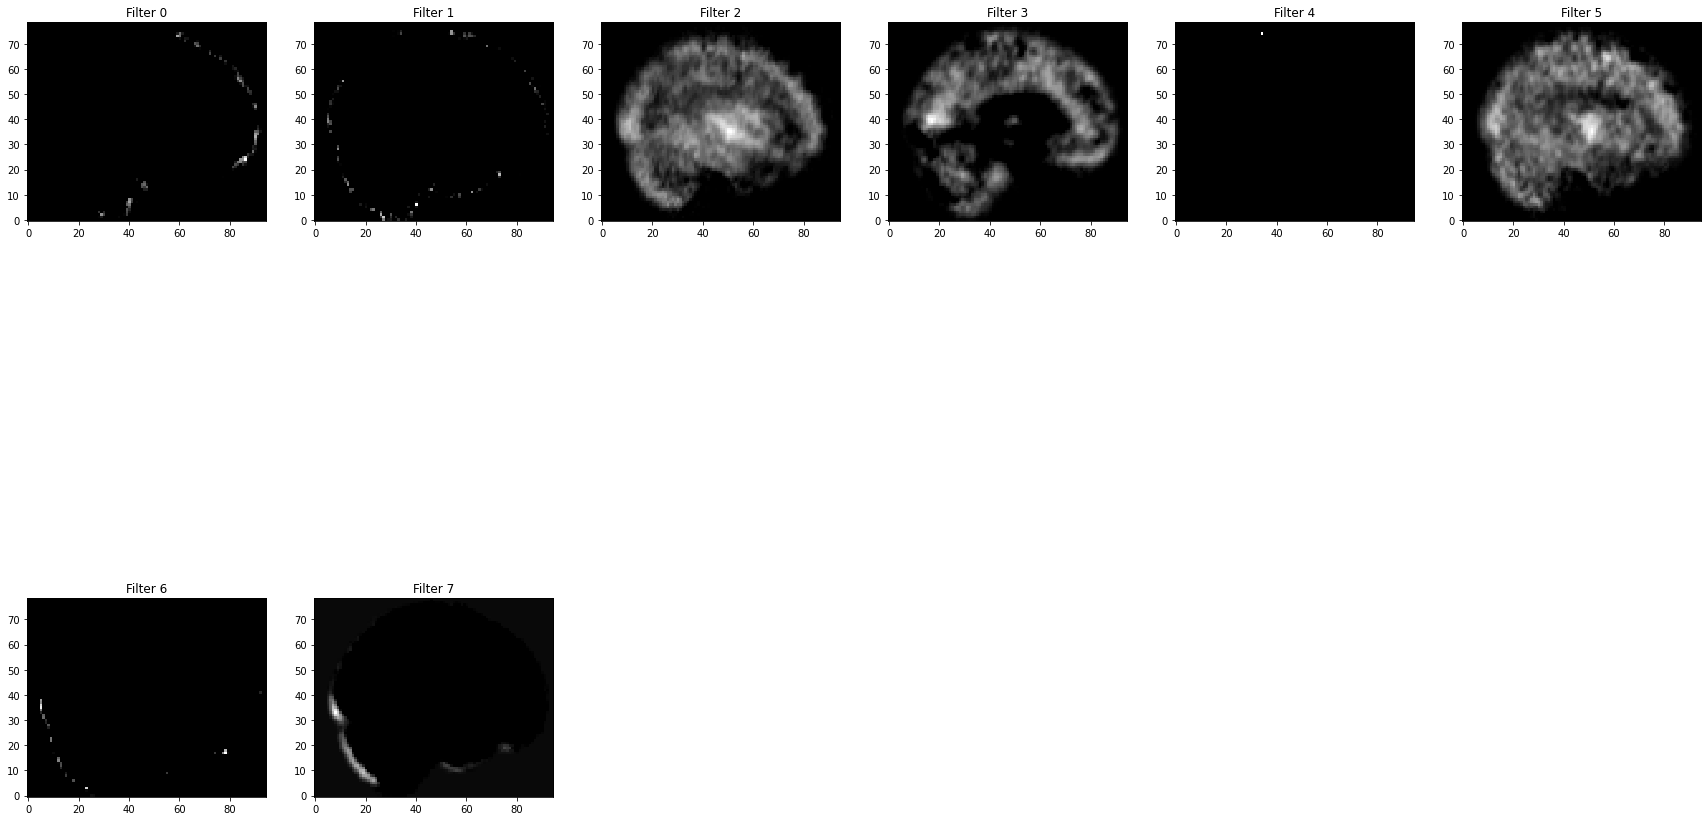

In [30]:
#make sure you named the layers when you constructed the model architecure!
#replace cnn1 with the name of the first CNN layer!
getActivations("conv1_1",np.expand_dims(all_data[250,:,:,:],axis=0))

Hm...interesting, some filters look at the outline of the brain, others look at the whole brain without concentrating to much on particular regions!

(1, 16, 95, 79)


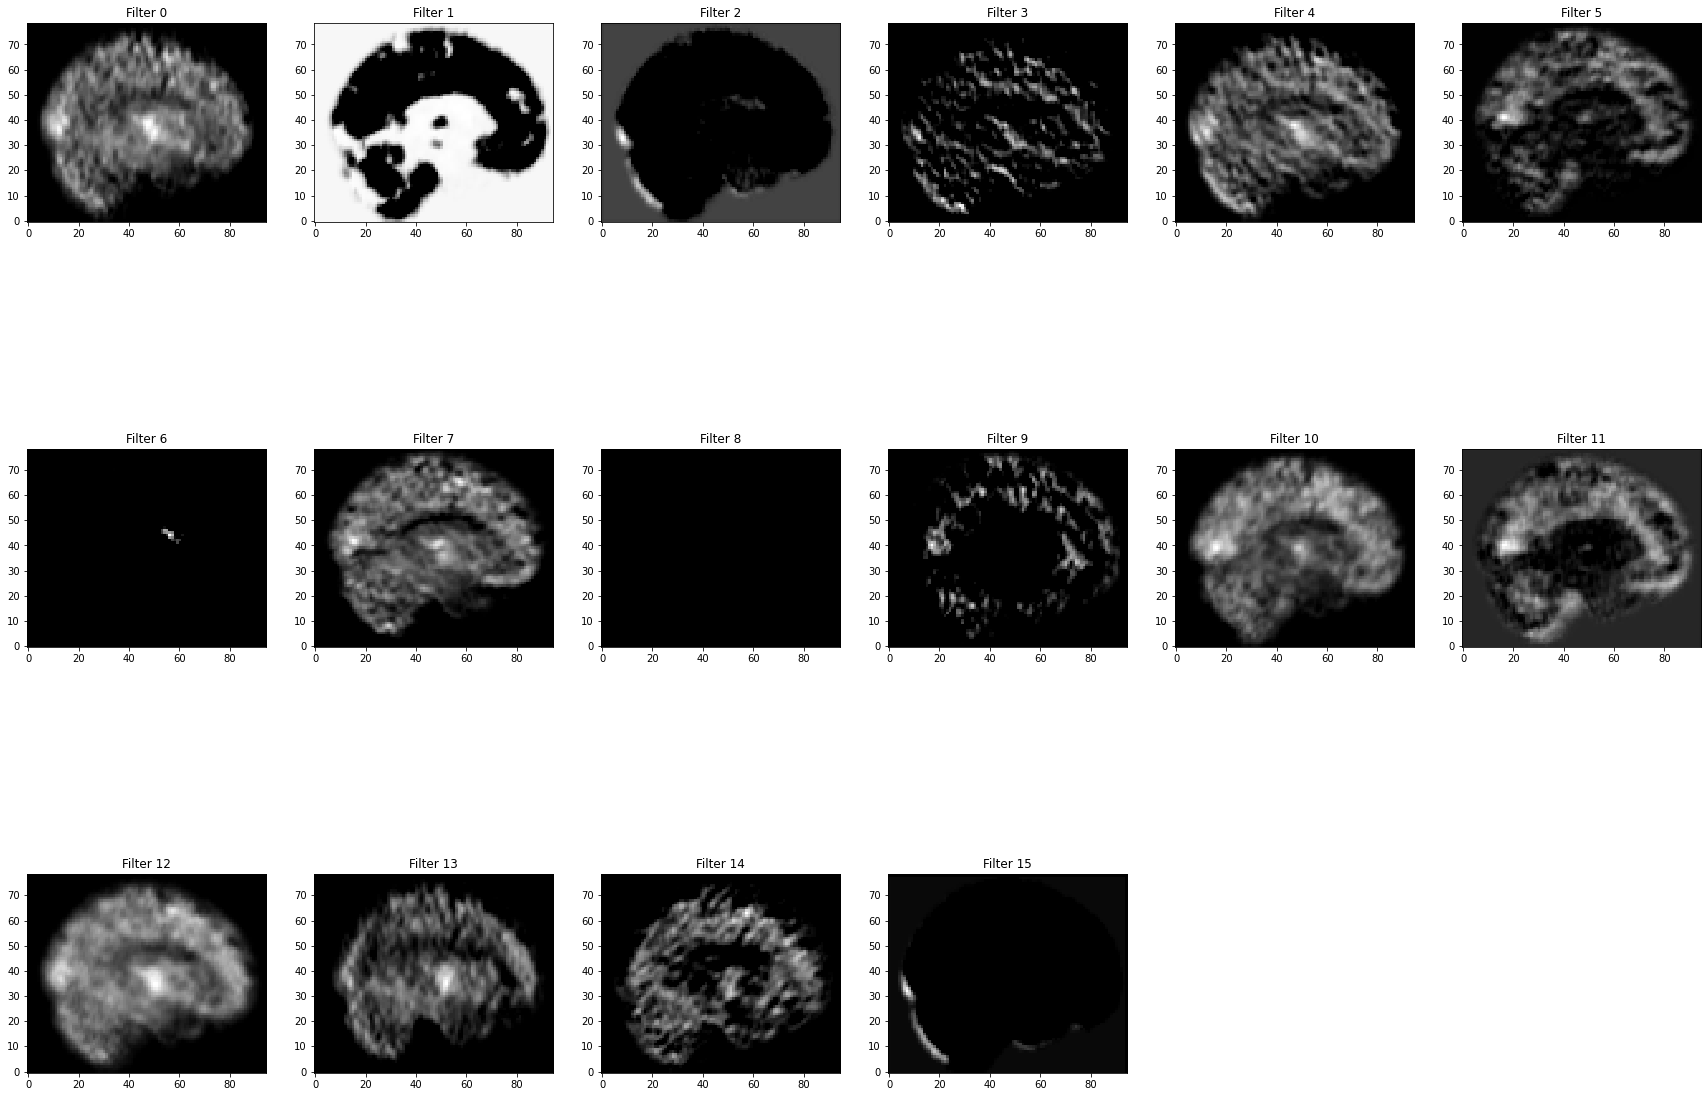

In [31]:
#make sure you named the layers when you constructed the model architecure!
#replace cnn1 with the name of the second CNN layer!
getActivations("conv1_2",np.expand_dims(all_data[250,:,:,:],axis=0))

We see something similar, filters look either at the whole brain or its outline!
Another way of looking at what the model has learned, is to plot the filter weights directly:

(3, 3, 79, 8)


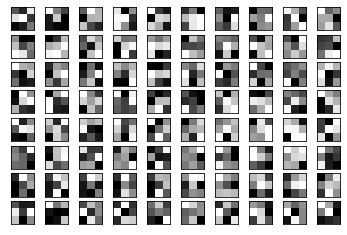

In [32]:
plot_filter_weights(new_model,"conv1_1",10)

What do you think these filters might detect? The dark squares indicate inhibitory weights and the light squares represent excitatory weights. Filters that gradiually change from light to dark indicate an edge detector. In our case we do not seem to identfy such explict edge detectors. This might indicate that our model does not seem to need edge-detectors for classifications. 


### Explaining model decisions using SHAP
So what specific area of on image promts our network to be exited positively, i.e. classify alzheimers? Lets use SHAP to find out!

In [33]:
import shap
#look for some examples to explain: normal brains
to_explain = all_data[150:170,:,:,:]
e = shap.GradientExplainer(new_model, all_data)
shap_values = e.shap_values(to_explain)

predictions: [[1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0]]


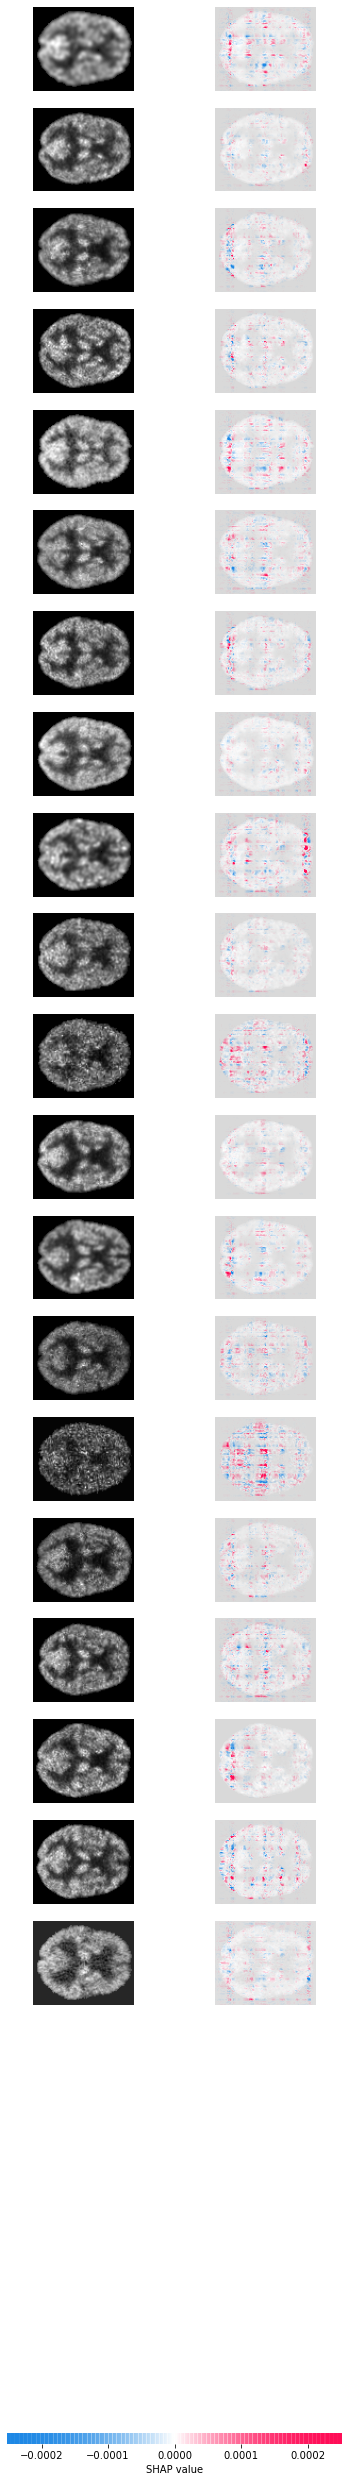

In [34]:
# plot the feature attributions
%matplotlib inline
#model predictions:
print(f"predictions: {np.round(new_model.predict(to_explain)).tolist()}")
slice_ = 40
#extract slice from shap values
slice_list = [x[:,:,:,slice_] for x in shap_values]

shap.image_plot(slice_list, to_explain[:,:,:,slice_].astype("float32"))


Red values correspond to higher model output (alzheimers), while blue correspondes to lower model output (healthy). Try different slices and different brains to explain!

# Visualizing saliency maps
Another way of visualizing what area of the image the network is concentrating on for classification, is the visualization of saliceny maps. It is similar to what SHAP is using to visualize model decisions. When feeding an image into your model, we record the gradients. We visualize these gradients, the higher the gradient, the more influence a particular area of the image has on the model output!

If you can, plot a 3d saliency map, otherwise, use slices!

In [35]:
#Plot the 3d saliency map or use slices of brain images. Overlay the brain image with the saliency map! 
#Demonstrate on healthy and ill brains!

import tensorflow as tf

#choose an image from all_data
pet_scan = all_data[1,:,:,:]

#add another dimention to the image since you model requires a specific input shape
_pet_scan = pet_scan.reshape((1, *pet_scan.shape))

#convert your image to a tensor
images = tf.Variable(_pet_scan, dtype="float32")

In [36]:
#compute the gradients

with tf.GradientTape() as tape:
    pred = model(images, training=False)
    class_idxs_sorted = np.argsort(pred.numpy().flatten())[::-1]
    loss = pred[0][class_idxs_sorted[0]]
    
grads = tape.gradient(loss, images)

In [37]:
#choose a slice you want to display
slice_ = 50

#compute the absolut of the gradients, make sure you only choose a slice!
dgrad_abs = tf.math.abs(grads[:,:,:,slice_])


dgrad_max_ = dgrad_abs[0]

In [38]:
#normalize to range between 0 and 1
grad_eval = tf.convert_to_tensor((dgrad_max_.numpy() - dgrad_max_.numpy().min()) / (dgrad_max_.numpy().max() - dgrad_max_.numpy().min()))

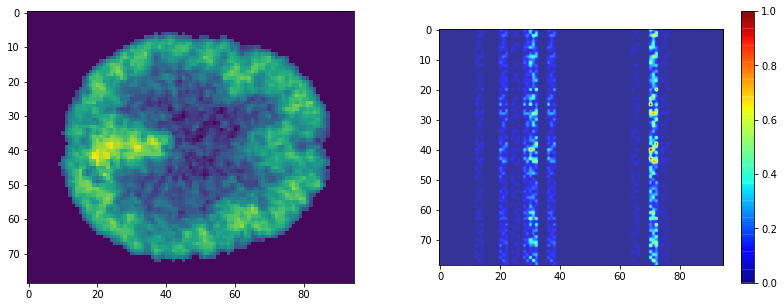

In [39]:
#plot saliency map and pet_scan you have chosen
fig, axes = plt.subplots(1,2,figsize=(14,5))
axes[0].imshow(pet_scan[:,:,slice_])
i = axes[1].imshow(grad_eval.numpy().astype(float),cmap="jet",alpha=0.8)
fig.colorbar(i)